# Machine Learning I, Programming Exercise 4

## Prerequisites
In this exercise, we will implement fundamental extensions to the support vector machine from last exercise. Copy the necessary code from programming exercise 2 to get the SVM running (with gradient descent and SGD) into the following cell. That means both the `fit(X, y)` and the `predict(X)` method should work correctly. If you didn't solve the last programming exercise, you can also copy the relevant parts from the sample solution that was uploaded to Olat.

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

def gradient_descent(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=1000, eps=1e-7):
    x = x_0.copy()
    trajectory = []
    
    if not callable(step_size):
        _step = lambda it: step_size
    else:
        _step = step_size
    
    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        x -= _step(i) * grad
        
        if np.sum(grad**2) < eps*eps:
            break
    
    return np.stack(trajectory, axis=-1)

def hinge_loss(t):
    return np.maximum(0, 1 - t)

def hinge_gradient(t):
    return np.where(t<1, -1, 0)

def svm_loss(w, b, C, x, y):
    """
        Returns: the loss in shape (m,) where m is the number of classes (m = 1 for binary classification)
    """
    return 0.5*np.sum(w**2, axis=0) + C/x.shape[0] * np.sum(hinge_loss(y*(np.matmul(x, w) + b)), axis=0)
# y*(np.matmul(x, w) + b has shape (n, m)
# hinge_loss(y*(np.matmul(x, w) + b)) has shape (n, m)
# np.sum(..., axis=0) sums over the n samples to produce a vector of length m (shape (m,))
# the 0.5*np.sum(w**2, axis=0) is a scalar, will be broadcasted to shape (m,) when added to the hinge loss

def svm_gradient(w, b, C, x, y):
    """
        Returns: the gradient in shape (d+1,) where d is the number of features

        w: shape (d,)
        
        b: shape (1,)
    """
    # Sorry for the mess, numpy's broadcasting rules are a bit verbose at times
    y = y.reshape(-1, 1) # make y a column vector (n, 1)
    w_bar = w.reshape(-1) \
            + C/x.shape[0] * np.sum(hinge_gradient(y*(np.matmul(x, w.reshape(-1, 1)) + b))*y*x, axis=0)
    
    # .reshape(-1) flattens the array to a 1D array

    # np.matmul(x, w.reshape(-1, 1)) + b -> (n, d) * (d,) + (1,) -> (n,)
    # y*(np.matmul(x, w.reshape(-1, 1)) + b) -> (n,1) * (n,) -> (n,)
    # (n,) * (n,d) -> (n,d)
    # np.sum(..., axis=0) sums over the n samples to produce a vector of length d (shape (d,))

    # w.reshape(-1, 1) is a column vector of shape (d, 1)

    b_bar = C/x.shape[0] * np.sum(hinge_gradient(y*(np.matmul(x, w) + b))*y)
    # No need to w.reshape(-1) because it has already been reshaped
    # np.matmul(x, w) + b -> (n, d) * (d,) + (1,) -> (n,)
    # y*(np.matmul(x, w) + b) -> (n,1) * (n,) -> (n,)
    # ... * y -> (n,)
    # np.sum(..., axis=0) sums over the n samples to produce a scalar (shape (1,))
    return np.append(w_bar, b_bar)


In [5]:
class SVM_GD(BaseEstimator, ClassifierMixin):
    def __init__(self, bias=True, C=1, step_size=0.01, max_iter=1000):
        super(SVM_GD, self).__init__()
        
        self.bias = bias
        self.C = C
        self.step_size = step_size
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        if self.bias:
            f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y) # returns (m,1) (scalar in binary classification)
            f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X, y) # returns [w, b] as [(d,1), (1,)]
        else:
            f = lambda w: svm_loss(w[:-1], 0, self.C, X, y)
            f_grad = lambda w: svm_gradient(w[:-1], 0, self.C, X, y)
        w_0 = np.random.standard_normal(X.shape[1]+1)
        
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)
        self.w = trace[:-1, -1]
        self.b = trace[-1, -1] if self.bias else 0
        return trace

    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    def decision_function(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Decision_function can only be called after supplying training data with fit first!')
        return np.matmul(X, self.w) + self.b
        # (n,d) * (d,) + (1,) -> (n,)
    
class SVM_SGD(SVM_GD):
    def __init__(self, bias=True, batch_size=32, C=1, step_size=0.01, max_iter=1000):
        super(SVM_SGD, self).__init__(bias, C, step_size, max_iter)
        
        self.batch_size = batch_size
    
    def fit(self, X, y):
        if self.bias:
            f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        else:
            f = lambda w: svm_loss(w[:-1], 0, self.C, X, y)
        
        def f_grad(w):
            from random import sample
            b = w[-1] if self.bias else 0
            w = w[:-1]
            # Sample a random batch from the training data
            batch_ind = sample(range(X.shape[0]), self.batch_size)
            return svm_gradient(w, b, self.C, X[batch_ind], y[batch_ind])
 
        w_0 = np.random.standard_normal(X.shape[1]+1) # random initialization of weights and bias (d+1,)
        
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)
        self.w = trace[:-1, -1]
        self.b = trace[-1, -1] if self.bias else 0
        return trace

## 1. Multi-class SVM
The support vector machines that we have implemented so far and also the theoretical model that was discussed in the lecture have one fundamental restriction: They can only distinguish between two classes and are therefore called *binary* classifiers. If we instead wish to assign a label to a data point from more than two possible choices, we call that a *multi-class* classification problem.

There are several models that extend the SVM so that it can deal with more than two classes, but in this exercise we are only going to have a look at one of the simplest possibilities: the *one-against-all* (OAA) approach. First, let $f: \mathcal{X} \to \mathbb{R}$ be the *decision function* of a two-class SVM, i.e.,
\begin{equation*}
    f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b.
\end{equation*}
Then the predicted label of $\mathbf{x}$ is just $\operatorname{sign}(f(\mathbf{x}))$. Also assume that we want to assign each datapoint a label from the set $\mathcal{Y} = \{1, \ldots, c\}$. As hinted by the name *one-against-all*, we can now train $c$ different binary classifiers ($f_i$ for each $i \in \mathcal{Y}$) with a slightly modified dataset: For classifier $f_i$ all datapoints with original label $i$ are relabeled to $1$ and all others are changed to $-1$. This is then a binary classification problem, which we know how to solve. That leaves us with the problem of "combining" the output of the $c$ classifiers to make a reasonable prediction. We accomplish that by using the following decision rule:
\begin{equation*}
    f(\mathbf{x}) = \operatorname{arg\ max}_{i \in \mathcal{Y}} f_{i}(\mathbf{x})
\end{equation*}

Your tasks are as follows:
1. Extend your SVM binary implementation(s) with a method `decision_function(X)` that implements $f$ as detailed above.
2. Implement the OAA algorithm inside the `OAA_SVM` class given in the code skeleton.
3. (optional) If you are bored and have nothing better to do, you can also have a look at the *one-against-one* strategy. As the name suggests, one binary classifier is trained for each pair of possible class labels. The predicted label is chosen by running all binary classifiers and choosing the class that was predicted most often. To avoid ties you can also sum up the decision function values for each class instead (but be careful with the signs).

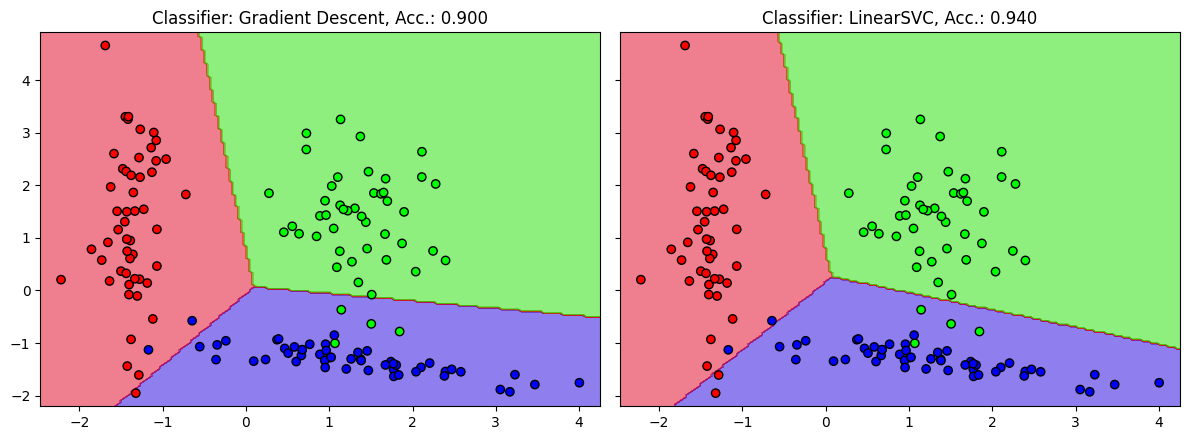

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

class OAA_SVM(BaseEstimator, ClassifierMixin):
    """
        One-Against-All SVM classifier
    """
    def __init__(self, svm_class, *svm_args, **svm_kwargs):
        """
            Args:
                svm_class: the class of the SVM to use. Could be SVM_GD or SVM_SGD
                *svm_args: positional arguments to pass to the SVM class
                **svm_kwargs: keyword arguments to pass to the SVM class

                classes is of shape (m,) where m is the number of classes

            Remarks:
                The svm_args and svm_kwargs will be passed to the
                svm_class when instantiated
        """
        super(OAA_SVM, self).__init__()
        
        self.bin_svms = None
        self.svm_class = svm_class
        self.svm_args = svm_args
        self.svm_kwargs = svm_kwargs # keyword arguments
        self.classes = None
    
    def fit(self, X, y):
        # e.g. y = [0, 1, 0, 2, 1, 0]
        # classes = [0, 1, 2]
        self.classes = np.unique(y) # get unique classes
        # self.classes will most likely be integers because y is usually integers
        # classes shape (m,) where m is the number of classes

        def train_bin_svm(c):
            """
                Train a binary SVM for class c

                Args:
                    c: the class to train the SVM for
            """
            # instantiate the SVM
            svm = self.svm_class(*self.svm_args, **self.svm_kwargs) 
            
            # data points whose class label is c are labeled 1, others -1
            y_bin = np.where(y==c, 1, -1) 
            # y_bin is a binary vector of shape (n,)
            # e.g. y_bin = [1, -1, -1, 1, 1, -1, ...]

            # train the SVM instance on the binary data
            svm.fit(X, y_bin)

            return svm
        
        # map over the classes to train a binary SVM for each class
        # e.g. classes = [0, 1, 2], then self.bin_svms = [svm_0, svm_1, svm_2]
        self.bin_svms = list(map(train_bin_svm, self.classes))
        # so each binary SVM is trained to distinguish between one class and all others
        # e.g. svm_0 distinguishes between class 0 and classes 1, 2
        
    def predict(self, X):
        if self.bin_svms is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        
        # Map over the binary SVM instances to get the decision function for each class
        scores = np.array(list(map(lambda svm: svm.decision_function(X), self.bin_svms)))
        # X has shape (n,d)
        # decision_function returns a vector of shape (n,) for each binary SVM
        # since we have m binary SVMs, scores has shape (m,n)
        # Imagine each row contains the decision function for each class for each sample
        # e.g. for 3 classes and 4 samples, 
        # scores = [
        #   [0.1, -0.2, 0.3, 0.5], 
        #   [-0.1, 0.2, -0.3, 0.1], 
        #   [0.2, 0.1, 0.3, -0.5]
        # ]
        max_ind = np.argmax(scores, axis=0)
        # max_ind is a vector of shape (n,)
        # where each element is the index of the class with the highest score
        # e.g. for the above example, max_ind = [2, 1, 0, 0]
        return self.classes[max_ind]
        # Imagine self.classes = [c_0, c_1, c_2]
        # then self.classes[max_ind] will be
        # [c_2, c_1, c_0, c_0]

        # Thus, self.classes[max_ind] returns the predicted class labels 
        # for each sample based on which binary classifier gave the highest score.


# Generate toy data
n = 200
# Notice the n_classes=3
X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=3,
                           n_clusters_per_class=1, class_sep=1.3, random_state=654321)
# class_sep = 1.3 means that the two classes are separated by a distance of 1.3
# The higher the value of class_sep, the more separated the two classes are

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

from sklearn.svm import LinearSVC
classifiers = [
    ('Gradient Descent', OAA_SVM(SVM_GD, C=1*n, bias=True, step_size=lambda t: 0.01/(t+1))),
    ('LinearSVC', LinearSVC(C=1))
]
# 💡 Notice how we passed SVM_GD as the SVM class to be used by OAA_SVM
# this means internally, OAA_SVM will use SVM_GD.train() to train the binary classifiers

# 💡 Notice that the step_size function is dynamic here: 0.01/(t+1)
# where t is the iteration number

# Plot decision surface
# First generate grid
res = 200  # Resolution of the grid in cells
# X shape: (n, 2)
x_max, y_max = np.max(X, axis=0) + 0.25
x_min, y_min = np.min(X, axis=0) - 0.25
# Get test array from grid
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
# grid_x and grid_y have shape (res, res)
# remember: c_ does column-wise concatenation
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]
# grid_input has shape (res*res, 2)

cmap = colors.ListedColormap([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
rows = (len(classifiers)+1)//2
fig, axes = plt.subplots(nrows=rows, ncols=2, sharex=True, sharey=True, figsize=(12, 4.5*rows))
for (name, clf), ax in zip(classifiers, axes):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test) # score function is inherited from ClassifierMixin
    grid_out = clf.predict(grid_input).reshape(grid_x.shape)
    # grid_input has shape (res*res, 2)
    # grid_out has shape (res, res)

    ax.set_title('Classifier: %s, Acc.: %.3f' % (name, score))
    ax.contourf(grid_x, grid_y, grid_out, alpha=0.5, cmap=plt.cm.brg) # brg is blue-red-green
    # grid_x, grid_y, and grid_out have shape (res, res)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap, edgecolor='k')
plt.tight_layout()
plt.show()
plt.close(fig)

## 2. Kernel SVM
In this exercise, we want to exploit the kernel trick and turn our linear SVM into a non-linear learning algorithm. Given a dataset $D = \{(\mathbf{x}^{(1)}, y^{(1)}), (\mathbf{x}^{(2)}, y^{(2)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})\}$ and a kernel function $k: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$, we can state the following optimization problem for the kernel SVM:
\begin{equation*}
    \min_{\boldsymbol{\alpha} \in \mathbb{R}^n, b \in \mathbb{R}} \frac{1}{2}  \boldsymbol{\alpha}^T K \boldsymbol{\alpha}  + \frac{C}{n} \sum_{i=1}^{n} \max\left(0, 1 - y^{(i)}\left(\sum_{j=1}^{n} \boldsymbol{\alpha}_j k(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) + b\right)\right),
\end{equation*}
where $K \in \mathbb{R}^{n \times n}$ is the so-called *kernel matrix* with $K_{ij} = k(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})$.

The steps to implement the kernel SVM will be pretty much the same as for the linear SVM from the last sheet:
1. Write a function `kernel_svm_gradient` that computes the gradient of the objective function above w.r.t. $\boldsymbol{\alpha}$ and $b$.


2. Implement a number of batched kernel functions. Given two matrices $X \in \mathbb{R}^{n \times d}$ and $X' \in \mathbb{n' \times d}$, those functions should return a matrix $K \in \mathbb{R}^{n \times n'}$ with $K_{ij} = k(X_i, X'_j)$, where $k: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$ is the kernel function in question:
    * The linear kernel: $k(\mathbf{x}, \mathbf{x}') = \langle \mathbf{x}, \mathbf{x}' \rangle$
    * The polynomial kernel: $k(\mathbf{x}, \mathbf{x}') = (\langle \mathbf{x}, \mathbf{x}' \rangle + c)^d$
    * The Gaussian (RBF) kernel: $k(\mathbf{x}, \mathbf{x}') = \exp\left(-\frac{1}{2\sigma^2} \lVert \mathbf{x} - \mathbf{x}' \rVert^2\right)$. **Hint:** $\lVert \mathbf{x} - \mathbf{x}' \rVert^2 = \lVert \mathbf{x} \rVert^2 - 2\langle \mathbf{x}, \mathbf{x}' \rangle + \lVert \mathbf{x}' \rVert^2$
    
   If you want to witness the results of your computations before dying of old age, I'd recommend *not* to use any `for` loops.


3. Implement the kernel SVM using (regular) gradient descent by filling in the gaps of the class `Kernel_SVM_GD`. Your implementation should accept one of the kernel functions from part 2 and use that to compute the kernel matrices necessary for training and prediction.


4. Repeat task 3, but this time use stochastic "gradient" descent to optimize the objective function. That is, choose a random batch $B \subset \{1, \ldots, n\}$ of a given size from the training data to compute the kernel matrix $K_{BB}$ (i.e., it should be restricted to only the data points in $B$) and update only the corresponding alphas.


5. Replace the Scikit-learn versions of the kernel SVM in the visualisation with your own and see if you can achieve similar results. You can then start plying around with kernel parameters to see what happens.

**Hint:** Don't be discouraged if you get very bad results at first, this is not necessarily due to a bug in your implementation. The kernel SVM is *very* sensitive to changes in the hyperparameters. Especially $\sigma$ for the RBF (Gaussian) kernel and the step size can have a huge influence on the end result. Try to log the value of the objective function during optimizaion to see if that explodes and experiment not just with constant step sizes, but try decaying step sizes as well (a step size in the order of $\mathcal{O}(1/t)$ is usually a good start). 

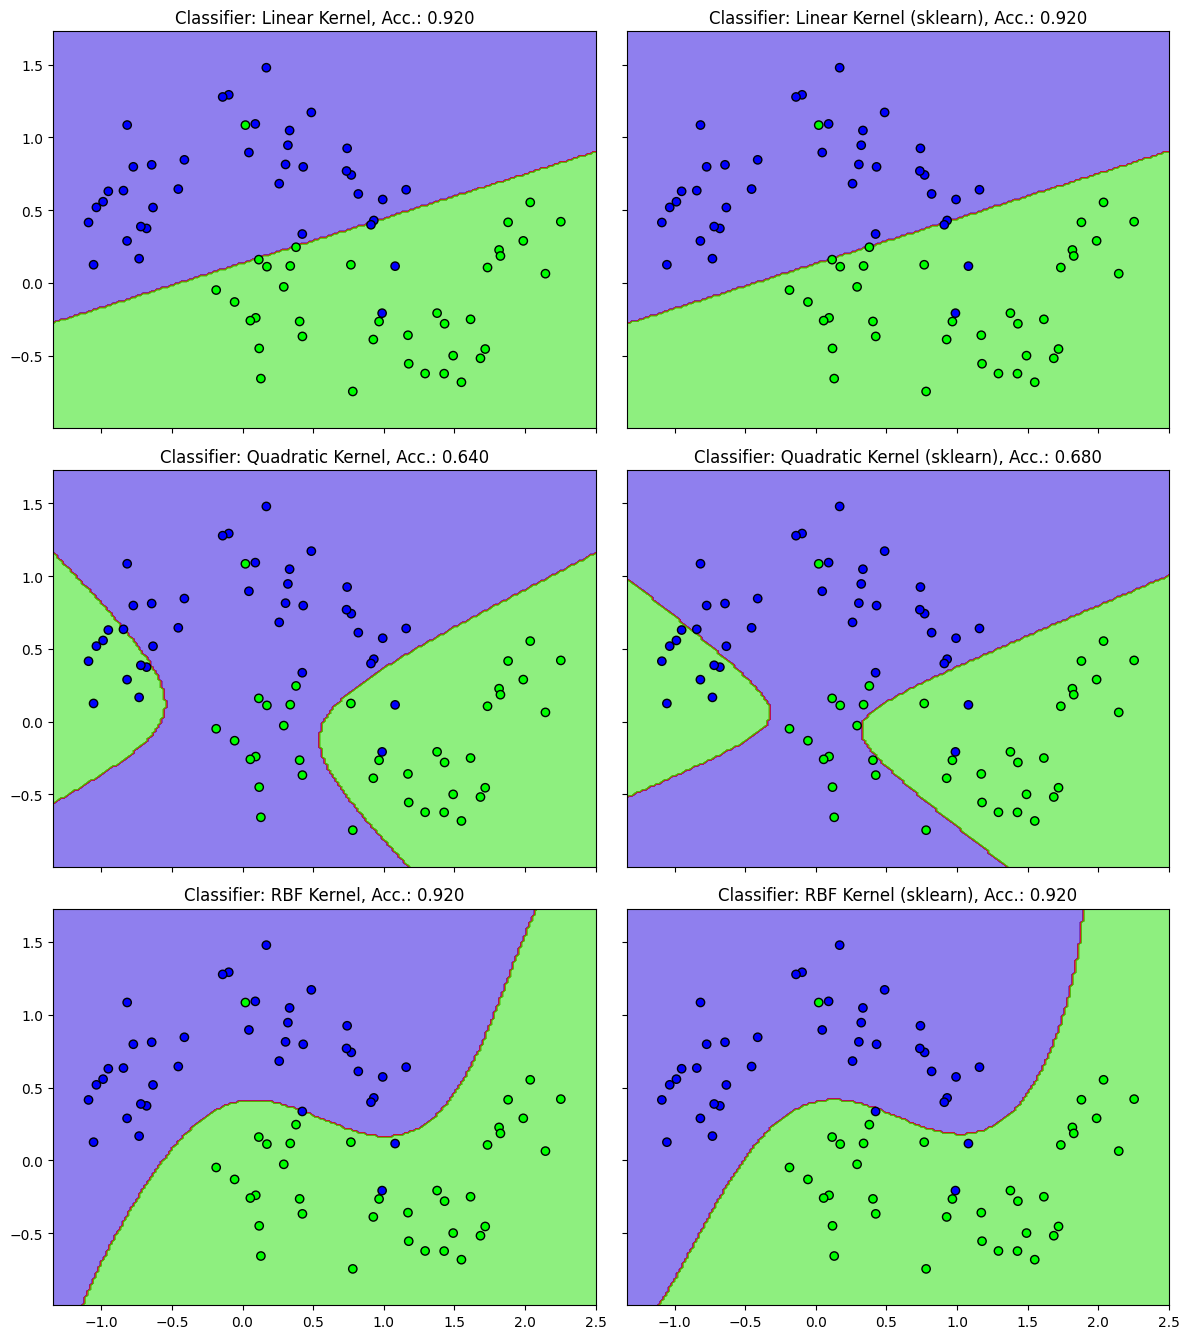

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

def kernel_svm_loss(alpha, b, C, K, y):
    """
        - alpha: shape (n,)
        - b: scalar
        - C: Regularization constant
        - K: Kernel matrix of shape (n,n)
           - K[i, j] represents the kernel value between the training points i and j.
        - y: shape (n,)
    """
    # Instead of X, we are passing the kernel matrix K directly
    return 0.5*np.matmul(alpha.T, np.matmul(K, alpha)) \
        + C/K.shape[0] * np.sum(hinge_loss(y*(np.matmul(K, alpha) + b)), axis=0)
    # The loss is a scalar

    # First term: 0.5*alpha^T K alpha
    # np.matmul(K, alpha) has shape (n,n) * (n,) -> (n,)
    # np.matmul(alpha.T, np.matmul(K, alpha)) has shape (1,n) * (n,) -> (1,)

    # * Second term: C/n * sum_i hinge_loss(y_i*(K_i^T alpha + b))
    # np.matmul(K, alpha) has shape (n,n) * (n,) -> (n,)
    # 
    # * y has shape (n,), and you are multiplying it element-wise 
    # by a vector of shape (n,) (which is the result of np.matmul(K, alpha) + b).

    # hinge_loss(y*(np.matmul(K, alpha) + b)  is applied element-wise to this vector, so the result will also be of shape (n,).

    # np.sum(hinge_loss(...), axis=0) sums over the n samples to produce a scalar (shape (1,))

def kernel_svm_gradient(alpha, b, C, K, y):
    """
        Args:
            alpha: shape (n,) in case of GD or (batch_size,) in case of SGD
            b: scalar
            C: Regularization constant
            K: Kernel matrix of shape (n,n)
               - K[i, j] represents the kernel value between the training points i and j.
               - ⚠️ The function is likely designed to handle K being either a matrix or a vector.
               - i.e. For Gradient Descent, K is a matrix, 
                      but for Stochastic Gradient Descent, K is a vector of the diagonal elements of the matrix K (i.e. K[batch_ind, batch_ind]) of shape (batch_size,)
            y: shape (n,)

        Returns: the gradient in shape (n+1,) where n is the number of samples
            [alpha_bar, b_bar]
    """
    # Sorry for the mess, numpy's broadcasting rules are a bit verbose at times
    y = y.reshape(-1, 1) # make y a column vector (n, 1)
    alpha_bar = np.matmul(K, alpha) \
            + C/K.shape[0] * np.sum(hinge_gradient(y*(np.matmul(K, alpha.reshape(-1, 1)) + b))*y*K, axis=0)
    
    # First term: np.matmul(K, alpha) has shape (n,n) * (n,) -> (n,)
    # Here we used the derivative rule: d/dalpha (alpha^T K alpha) = (K + K^T) alpha = 2K alpha

    # ⚠️ SGD Case:
    # np.matmul(K, alpha) has shape (batch_size,) * (batch_size,) -> scalar

    # Second term:
    # np.matmul(K, alpha) has shape (n,n) * (n,) -> (n,)
    # y*(np.matmul(K, alpha) + b) is multiplied element-wise by y, so it has shape (n,)
    # hinge_gradient is applied element-wise to this vector, so the result will also be of shape (n,)
    # hinge_gradient(...) * y still has shape (n,)
    # ... * y * K -> Here since K is nxn, we are broadcasting the (n,) vector to (n,n) by multiplying it by K
    # The result now is of shape (n,n)
    # But alpha_bar should be of shape (n,), so we sum over the columns to get a vector of shape (n,)

    # ⚠️ SGD Case:
    # np.matmul(K, alpha) has shape (batch_size,) * (batch_size,) -> scalar
    # y*(np.matmul(K, alpha) + b) is multiplied element-wise by y, so it has shape (batch_size,)
    # hinge_gradient is applied element-wise to this vector, so the result will also be of shape (batch_size,)
    # hinge_gradient(...) * y still has shape (batch_size,)
    # ... * y * K -> Here since K is a vector of shape (batch_size,) then the result will be
    # (batch_size,) * (batch_size,) -> (batch_size,) element-wise multiplication

    b_bar = C/K.shape[0] * np.sum(hinge_gradient(y*(np.matmul(K, alpha.reshape(-1, 1)) + b))*y)
    # np.matmul(K, alpha) has shape (n,n) * (n,) -> (n,)
    # y*(np.matmul(K, alpha) + b) is multiplied element-wise by y, so it has shape (n,)
    # hinge_gradient is applied element-wise to this vector, so the result will also be of shape (n,)
    # hinge_gradient(...) * y still has shape (n,)
    # ... * y -> multiplication is element-wise, so the result is of shape (n,)
    # np.sum(hinge_gradient(...), axis=0) sums over the n samples to produce a scalar (shape (1,))
    
    return np.append(alpha_bar, b_bar)

class Kernel_SVM_GD(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel_func, bias=True, C=1, step_size=0.01, max_iter=1000):
        super(Kernel_SVM_GD, self).__init__()
        
        self.kernel_func = kernel_func
        self.bias = bias
        self.C = C
        self.step_size = step_size
        self.max_iter = max_iter
        self.alpha = None # instead of w, here we have alpha
        self.b = None
        self.X_train = None # to keep a copy of the training data because X will be used to compute the kernel matrix

    def fit(self, X, y):
        # Precompute kernel matrix
        self.X_train = X.copy()
        K = self.kernel_func(X, X)
        
        if self.bias:
            f = lambda alpha: kernel_svm_loss(alpha[:-1], alpha[-1], self.C, K, y)
            f_grad = lambda alpha: kernel_svm_gradient(alpha[:-1], alpha[-1], self.C, K, y)
        else:
            f = lambda alpha: kernel_svm_loss(alpha[:-1], 0, self.C, K, y)
            f_grad = lambda alpha: kernel_svm_gradient(alpha[:-1], 0, self.C, K, y)
        
        alpha_0 = np.zeros(X.shape[0]+1) # (n+1,) for alpha and b
        
        trace = gradient_descent(f, f_grad, None, alpha_0, step_size=self.step_size, max_iter=self.max_iter)
        # trace has shape (n+1, max_iter)
        # e.g. [
        #   [alpha_0^0, alpha_0^1, ..., alpha_0^T], 
        #   [alpha_1^0, alpha_1^1, ..., alpha_1^T], 
        #   ..., 
        #   [alpha_n^0, alpha_n^1, ..., alpha_n^T],
        #   [b^0, b^1, ..., b^T]]
        # ] where T is the number of iterations
        self.alpha = trace[:-1, -1] # [alpha_0^T, alpha_1^T, ..., alpha_n^T]
        self.b = trace[-1, -1] if self.bias else 0 # b^T
        return trace

    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    def decision_function(self, X):
        """
            X: shape (n, d) is the test data matrix 🧪
        """
        if self.alpha is None or self.b is None:
            raise ValueError('Decision_function can only be called after supplying training data with fit first!')
            
        K = self.kernel_func(X, self.X_train) 
        # X is the test data matrix, 
        # self.X_train is the training data matrix
        return np.matmul(K, self.alpha) + self.b
    
class Kernel_SVM_SGD(Kernel_SVM_GD):
    def __init__(self, kernel, batch_size, bias=True, C=1, step_size=0.01, max_iter=1000):
        super(Kernel_SVM_SGD, self).__init__(kernel, bias=bias, C=C, step_size=step_size, max_iter=max_iter)
        
        self.batch_size = batch_size

    def fit(self, X, y):
        # Precompute kernel matrix
        self.X_train = X.copy()
        self.Y_train = y.copy()
        K = self.kernel_func(X, X)
        
        if self.bias:
            f = lambda alpha: kernel_svm_loss(alpha[:-1], alpha[-1], self.C, K, y)
        else:
            f = lambda alpha: kernel_svm_loss(alpha[:-1], 0, self.C, K, y)
            
        def f_grad(alpha):
            from random import sample
            b = alpha[-1] if self.bias else 0
            alpha = alpha[:-1]
            # Sample a random batch from the training data
            batch_ind = sample(range(X.shape[0]), self.batch_size)
            grad = kernel_svm_gradient(alpha[batch_ind], b, self.C, K[batch_ind, batch_ind], y[batch_ind])
            # ⚠️ K[batch_ind, batch_ind] will not produce a square matrix. Instead, it will return the diagonal elements of the matrix K
            # i.e. It will have shape (batch_size,)

            # 💡 Explanation:
            # - In full kernel SVMs, you would use the entire kernel matrix, or at least a square submatrix for a batch.
            # - However, in SGD, you're typically trying to reduce the computational complexity, and one way to do that is to use only the diagonal elements (self-similarities) of the kernel matrix, which reduces the amount of computation per iteration.

            # In this case, the f_grad function only uses the diagonal elements for the batch, which simplifies the calculation while still moving the parameters in the correct direction during gradient descent.

            # Scatter partial gradient back to original size

            # f_grad must return a vector of shape (n+1,)
            # but now grad has shape (batch_size,)
            # so we need to fill up the rest of the vector with zeros to have shape (n+1,)

            full_grad = np.zeros(X.shape[0]+1, dtype=alpha.dtype) # (n+1,)
            full_grad[batch_ind] = grad[:-1] # grad[:-1] is alpha_bar
            full_grad[-1] = grad[-1] # grad[-1] is b_bar
            return full_grad          
            
        alpha_0 = np.zeros(X.shape[0]+1)
        
        trace = gradient_descent(f, f_grad, None, alpha_0, step_size=self.step_size, max_iter=self.max_iter)
        self.alpha = trace[:-1, -1]
        self.b = trace[-1, -1] if self.bias else 0
        return trace


def linear_kernel(X1, X2):
    """
        X1 and X2 could be the same matrix or different matrices of shape (n, d)
    """
    return np.matmul(X1, X2.T)

def poly_kernel(c=0, d=1, gamma=1):
    """
    Args:
        c: constant term >= 0
        d: degree of the polynomial kernel, should be an integer >= 1
        gamma: coefficient of the polynomial kernel, should be a float >= 0

    Remarks:
        The purpose of gamma is to control the influence of higher-degree polynomials.
        If gamma is too high, the higher-degree polynomials will have a stronger influence on the decision boundary.

    Returns: a function that computes the polynomial kernel
    """
    def kernel(X1, X2):
        return np.power(gamma*np.matmul(X1, X2.T) + c, d)
    return kernel

def rbf_kernel(sigma=1):
    """
    Radial Basis Function (RBF) Kernel (also known as the Gaussian Kernel).

    The RBF kernel is a widely used kernel in machine learning, especially for support vector machines (SVMs). 
    It measures the similarity between two points in the feature space based on the Euclidean distance between them.
    
    Args:
        sigma (float): The width parameter of the RBF kernel. It controls how much influence a training sample has on the decision boundary.
                       - A smaller sigma value leads to a narrow Gaussian, where points must be closer to each other to be considered similar.
                       - A larger sigma value makes the Gaussian broader, leading to smoother decision boundaries, allowing more points to be considered similar.
                       The width of the Gaussian determines how quickly the similarity decays as the distance between points increases.

    Returns:
        kernel (callable): A function that takes two datasets X1 and X2 (each as numpy arrays of shape (n_samples, n_features)) and returns their RBF kernel matrix.
        
    The returned function computes the pairwise similarity between each pair of points from X1 and X2. The output is a matrix where each entry 
    K[i, j] represents the similarity between the i-th point in X1 and the j-th point in X2, computed as:
        
        K[i, j] = exp(-||x1_i - x2_j||^2 / (2 * sigma^2))
    
    The value of K[i, j] ranges between 0 and 1:
        - When ||x1_i - x2_j|| is small (i.e., the points are close), K[i, j] will be close to 1.
        - When ||x1_i - x2_j|| is large (i.e., the points are far apart), K[i, j] will be close to 0.

    The RBF kernel is highly effective for non-linear decision boundaries, as it projects data into an infinite-dimensional space, 
    where even non-linearly separable data in the original space can become linearly separable.

    Explanation of the Kernel Matrix:
    ---------------------------------
    The RBF kernel matrix encodes the similarity between all pairs of points from two datasets, X1 and X2:
        - If X1 has n samples and X2 has m samples, the resulting kernel matrix K will have dimensions (n, m).
        - Each entry K[i, j] represents the similarity between the i-th point of X1 and the j-th point of X2.
    
    The RBF kernel uses the squared Euclidean distance between points to compute the similarity, but it decays exponentially with distance. This means that 
    points that are close to each other (in terms of Euclidean distance) will have a high similarity score, while distant points will have a low similarity score.
    
    Impact of Sigma (σ):
    -------------------
    Sigma controls the "spread" or "sensitivity" of the kernel:
        - **Small σ:** 
            - The kernel is highly sensitive to distance.
            - Only points that are very close to each other will be considered similar (high kernel value close to 1).
            - This can result in a complex decision boundary that overfits the training data.
        - **Large σ:**
            - The kernel is less sensitive to distance.
            - Even points that are farther apart will have a significant similarity score, resulting in a smoother decision boundary.
            - This can help reduce overfitting, but if σ is too large, the model may underfit, as many points will be considered similar even if they are distant.
            
    Example:
        For two points x1 and x2 in feature space, their RBF kernel value is given by:
        
            K(x1, x2) = exp(-||x1 - x2||^2 / (2 * sigma^2))

        If x1 and x2 are close to each other (i.e., small ||x1 - x2||), the kernel value will be close to 1. If they are far apart, the kernel value will be close to 0.

        # (n, d) = (2, 3)
        X1 = np.array([
            [1, 5, -3],
            [2, 1, -1]
        ])

        # (n, d) = (2, 3)
        X2 = np.array([
            [4, 5, -2],
            [2, 0, -1],
        ])

        kernel = rbf_kernel(1.5)

        print(kernel(X1, X2))

        # Output:
        [[0.10836802 0.00127263]
         [0.00940356 0.8007374 ]]

         The second array could also be of shape (m, n) where m is the number of samples in X2
         and not necessarily equal to n, the number of samples in X1
         X1 (n=2,d=3) and X2 (m=4,d=3) would still be valid inputs and the output would be of shape (2, 4)
    """
    def kernel(X1, X2):
        # Compute the squared Euclidean distance between each pair of points in X1 and X2
        sqdist = np.sum(X1**2, axis=1, keepdims=True) - 2*np.matmul(X1, X2.T) + np.sum(X2**2, axis=1, keepdims=True).T

        # - np.sum(X1**2, axis=1, keepdims=True) has shape (n,1)
        # - np.matmul(X1, X2.T) has shape (n,m)
        # - np.sum(X2**2, axis=1, keepdims=True).T has shape (1,m)
        # With broadcasting, the final sqdist will have shape (n,m)

        # Compute the RBF kernel matrix using the Gaussian function
        return np.exp(-sqdist / (2 * sigma**2))
    
    return kernel

# Generate toy data
n = 100
X, Y = make_moons(n, noise=0.2, random_state=123456)
# Change labels from 0,1 to -1,1
Y *= 2; Y -= 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

# You can also try a dataset with more than 2 classes
# X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=3,
#                           n_clusters_per_class=1, class_sep=1.3, random_state=654321)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)


from sklearn.svm import SVC
classifiers = [
    ('Linear Kernel', Kernel_SVM_GD(linear_kernel, C=1*n, bias=True, step_size=lambda t: 0.1/(t+1))),
    ('Linear Kernel (sklearn)', SVC(C=1, kernel='linear')),
    ('Quadratic Kernel', Kernel_SVM_GD(poly_kernel(0, 2, 0.88), C=1*n, bias=True, step_size=lambda t: 0.1/(t+1))),
    ('Quadratic Kernel (sklearn)', SVC(C=1, kernel='poly', degree=2, gamma=0.88, coef0=0)),
    ('RBF Kernel', Kernel_SVM_GD(rbf_kernel(0.75), C=1*n, bias=True, step_size=lambda t: 0.1/(t+1))),
    ('RBF Kernel (sklearn)', SVC(C=1, gamma=0.88))  # here, gamma = 1/(2*sigma**2), since we used sigma=0.75, then gamma = 1/(2*0.75**2) = 0.88
]

# Plot decision surface
# First generate grid
res = 200  # Resolution of the grid in cells
x_max, y_max = np.max(X, axis=0) + 0.25
x_min, y_min = np.min(X, axis=0) - 0.25
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
# both grid_x and grid_y have shape (res, res)

# Get test array from grid
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]
# grid_input has shape (res*res, 2)

cmap = colors.ListedColormap([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
rows = (len(classifiers)+1)//2
fig, axes = plt.subplots(nrows=rows, ncols=2, sharex=True, sharey=True, figsize=(12, 4.5*rows))

for (name, clf), ax in zip(classifiers, axes.ravel()):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test) # X_test size is 0.25*n = .25 * 100 = 25
    # Call predict for the (res*res, 2) dataset, then the result will have shape (res*res,)
    # Then reshape the result to (res, res) to plot the decision

    # e.g. Let res=2
    # grid_input = [
    #   [1, 2], 
    #   [1, 3],
    #   [2, -3],
    #   [2, 4]
    # ] -> shape (2*2, 2)

    # when you call clf.predict(grid_input), you will get a vector of shape (2*2,)
    # e.g. [1, -1, -1, 1]
    # Then you reshape it to (2, 2) to plot the decision surface
    # e.g. [
    #   [1, -1],
    #   [-1, 1]
    # ]
    grid_out = clf.predict(grid_input).reshape(grid_x.shape) 

    ax.set_title('Classifier: %s, Acc.: %.3f' % (name, score))
    ax.contourf(grid_x, grid_y, grid_out, alpha=0.5, cmap=plt.cm.brg)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap, edgecolor='k') # 75 training samples
plt.tight_layout()
plt.show()
plt.close(fig)

## 3. Model Selection & Model Evaluation
Now that we have a working algorithm for the general kernel SVM, it is only natural to try it out on a somewhat more complex task than the two dimensional toy datasets that we have used up until now. However, we need to address two problems that naturally arise in  virtually any application of machine learning:
1. *Model evaluation*: This refers to the idea that we want to know how good or bad our model performs after we have trained it. Actually, we are interested in the performance (e.g. classification accuracy) that we can expect from a model when we apply it to real-world data it has never seen before. Ideally, we would have an infinite and highly available stream of real-world data which we could use to evaluate the model, but data is quite often a rare and precious resource in machine learning and we have to make the best out of what is available to us.

   Using the same data for evaluation that we have already used for training is clearly not a good idea, since that would only estimate the performance on already seen data. A popular solution to the problem is to randomly split the available data into a *training set* that is used for training the model and a *test set* that is held out from the training procedure and then used for evaluating the model. In general, this is not a bad idea and often used in practice, but with this approach, we could be unlucky and, by chance, the test set might not be very representative of the true underlying real-world data distribution. The point estimate we recieve could be way off in this case. An improvement to this method is *cross validation*, which you have already seen in the lecture. Here, we randomly split the data into $k$ folds of the same size before using one fold as the test set and the rest for training. We repeat this procedure $k$ times so that each fold has been used for testing exactly once and in the end we recieve a distribution for the performance of the model.


2. *Model selection*: Another problem that we need to address is that of *model selection*. This refers to the procedure of finding a good model for the underlying task. Two different models don't need to be prduced by different algorithms, instead the models that we get when running the SVM algorithm with $C=1$ and $C=10$, respectively, would be considered different in this context. In fact, model selection often coincides with hyperparameter search for a specific algorithm. A simple, yet often used, approach to this problem is called *grid search*. A priori, we define a list of possible values for each hyperparameter and then simply evaluate the performance of the resulting model for every possible combination of those hyperparameter values. Again, measuring the performance could be achieved using a train-test-split or cross validation, as detailed in 1. After we have tested all possible combinations, we simply pick the one with the highest estimated performance.


Now, the question that would naturally arise in this scenario is, whether this performance estimate for the best model is a good estimator of the model's performance on unseen data. Unfortunately, the answer is no, since we have used the held-out test data to make decisions about the hyperparameters of the model, meaning that we implicitely "leaked" information on the test data by choosing the hyperparameters that yield the best performance on it.

Clearly, we need to hold out another portion of the data from the model selection procedure, so that we can finally estimate the model's performance on this unseen subset. In the simplest case, we split the data into three subsets:
* The *test set*, which we use to estimate the model's performance after the whole procedure and
* The *training* and *validation set*, which are used for model selection.

As mentioned above, we could also use cross validation to estimate the performance of whatever comes out of the model selection process, resulting in what is usually called *nested cross validation*. The name stems from the observation that we use cross validation to estimate the model's performance in the "outer" loop and also during model selection in the "inner" loop. The following image shows how the data would be divided for $k=5$ in the outer loop and $k=2$ in the inner loop:

<figure>
  <img src="https://miro.medium.com/max/1400/1*8WAHvOZkLwtwFLwWPVNhow.png" style="padding: 5px; border: 2px solid #000; max-width:700px; max-height:700px;" />
  <figcaption style="text-align: center;">Data splits in nested cross validation (<a href="https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7">source</a>).</figcaption>
</figure>

Another, more mathematically founded explanation can be found in a machine learning textbook of your choice, for example in "[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)" by M. P. Deisenroth, A. A. Aldo Faisal, and C. S. Ong (see chapter 8.6, p. 284).

In this exercise, we will use nested cross validation to estimate the performance of our SVM implementstion on a somewhat more complex and difficult dataset.
1. Write a function `cross_validation` that takes the following arguments:
    * The classifier whose performance we want to estimate. It should implement both the `fit(X, y)` and the `score(X, y)`method.
    * Training data in the form of an `(X, y)` tuple.
    * The number of folds $k$.
   
   The function should implement "normal" cross validation and return the resulting scores as an array of length $k$.


2. Write a function `grid_search` that takes the following arguments:
    * An arbitrary function $f$, called the *objective*. We want to find the arguments that maximize this function.
    * A grid of function parameter values to test. This should be a dictionary that has the arguments of $f$ as its keys and a list of values that we want to try for those arguments as its values.
   
   Assume that the function is $f(a, b) = a^2 - 6b$ and that we receive the parameter dictionary `{'a': [1, 2, 3], 'b': [5, 6, 7]}`. Then we would plug in each possible combination of $a$ ad $b$ into $f$, i.e., $f(1, 5), f(1, 6), f(1, 7), f(2, 5), \ldots, f(3, 7)$. The function should return the parameters that maximized the objective function and the value of the objective function that is obtained when plugging in those parameters. In the example those would be $a=3, b=5$ and $f(3, 5) = -21$.


3. Implement a class `GridSearch` that emulates a classifier by training an underlying base classifier with grid search. Its constructor should take the following arguments:
    * A factory function that takes an arbitrary set of parameters and returns an instance of the base classifier with the specified parameters.
    * A parameter grid, on which the grid search should be performed. Should have the same format as for the gird search function from 2.
    
   Additionally, the class itself should implement the following methods:
    * `fit(X, y)`: Find the parameters from the given parameter grid that maximize the base classifier's performance by using the grid search function from 2. After that, train the base model using the best parameters and all available data.
    * `score(X, y)`: Here, you can simply pass the call to the trained base classifier.


4. Use all of the above to implement nested cross validation as a function. It should take the following arguments:
    * A factory function like in 3.
    * Training data in the form of an `(X, y)` tuple.
    * A grid of function parameter values to test, like in 2.
    * Two parameters `k_inner` and `k_outer` for setting the number of folds for the inner and the outer cross validation loop, respectively.


5. Finally, use nested cross validation to estimate the performance of your multi-class kernel SVM implementation on Scikit-Learn's [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits). Use $k=5$ for both the inner and outer loop and standardize the data before passing it to the classifier. It is recommended that you stick to the RBF kernel and test different values for $\sigma$ and $C$ only. Try to keep the parameter grid relatively small so that the search doesn't take forever. You should be able achieve more than 90% mean cross validation accuracy.

**Hint:** Running the nested cross validation might be really slow, depending on your hardware. Try to report progress regularly so that you can see how far the process got and that you can estimate the remaining time. If you find that your implementation is way too slow, you can also take Scikit-Learn's `SVC` class as the underlying classifier instead.

In [19]:
from typing import Callable, Dict, List, Tuple, Any, Union
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def cross_validation(clf, X, Y, k=5):
    """
        Perform k-fold cross-validation on the classifier
        Computes the accuracy of the classifier on each fold

        Args:
            clf: the classifier instance e.g. OAA_SVM, Kernel_SVM_GD, Kernel_SVM_SGD
            X: the data matrix (n, d)
            Y: the target labels (n,)
            k: the number of folds

        Returns: an array of shape (k,) containing the accuracy of the classifier on each fold
    """
    n = X.shape[0]
    indices = np.random.permutation(n) # shuffle the indices. shape (n,)
    mask = np.full_like(Y, False, dtype=np.bool) # create a boolean mask of shape (n,) filled with False
    fold_sizes = [n//k + int(i<(n%k)) for i in range(k)] # compute the size of each fold
    # e.g. n=10, k=3, fold_sizes = [4, 3, 3]
    
    scores = []
    
    for fold in range(k):
        start = sum(fold_sizes[:fold])
        end = sum(fold_sizes[:fold+1])
        fold_ind = indices[start:end]
        X_test, Y_test = X[fold_ind], Y[fold_ind]
        mask[...] = True # set all elements to True
        mask[fold_ind] = False # set the test indices to False to keep them out of the training set
        X_train, Y_train = X[mask], Y[mask]
        
        clf.fit(X_train, Y_train)
        scores.append(clf.score(X_test, Y_test))
    
    return np.array(scores)

def grid_search(
    func: Callable[..., np.ndarray], param_grid: Dict[str, List[Any]]
) -> Tuple[Dict[str, Any] | None, float]:
    """
    Args:
        func: the objective function to optimize. We want to find the parameters that maximize this function.
        func returns an array of scores of shape (k,) where k is the number of folds

        param_grid: a dictionary of the form {param_name: [param_values]}

    Returns: a tuple (best_params, best_score) where best_params is a dictionary of the best parameters and best_score is the best score the objective function achieved with these parameters.

    Example:
    >>> param_grid = {
    >>>   "c": [1, 10],
    >>>   "sigma": [1, 2, 3]
    >>> }

    >>> grid_search(func, param_grid)
    """
    from itertools import product

    best_params: Dict[str, Any] | None = None
    best_score: float = -float("inf")

    # the * operator unpacks the values of the dictionary into a list of tuples:
    # param_grid = {
    #   "c": [1, 10],
    #   "sigma": [1, 2, 3]
    # }
    # list(product(*param_grid.values())) will produce:
    # [(1, 1), (1, 2), (1, 3), (10, 1), (10, 2), (10, 3)]

    for params in product(*param_grid.values()):
        param_dict: Dict[str, Any] = {k: v for k, v in zip(param_grid.keys(), params)}
        # e.g. param_dict = {"c": 1, "sigma": 2}

        score = func(**param_dict).mean() # func returns numpy.ndarray
        # *: Unpacks iterables like lists or tuples into positional arguments (i.e., passed by position).
        
        # **: Unpacks dictionaries into keyword arguments (i.e., passed by name).

        print(f"params: {param_dict}, score: {score:.3f}")
        if score > best_score:
            best_score = score
            best_params = param_dict

    print(best_params)

    return best_params, best_score

class GridSearch:
    def __init__(self, clf_factory, param_grid, cv_k=5):
        self.clf = None
        self.clf_factory = clf_factory
        self.param_grid = param_grid
        self.cv_k = cv_k

    def fit(self, X, y):
        def inner_eval(X, y, **params):
            clf = self.clf_factory(**params)
            return cross_validation(clf, X, y, k=self.cv_k)
        
        param_grid = dict(self.param_grid)
        param_grid.update(dict(X=[X], y=[y]))
        best_params, _ = grid_search(inner_eval, param_grid)
        best_params.pop('X')
        best_params.pop('y')
        self.clf = self.clf_factory(**best_params)
        self.clf.fit(X, y)

    def score(self, X, y):
        if self.clf is None:
            raise ValueError('Score can only be called after supplying training data with fit first!')
        
        return self.clf.score(X, y)

def nested_cross_validation(clf_factory, X, y, param_grid, outer_k=5, inner_k=5):   
    wrapper = GridSearch(clf_factory, param_grid, cv_k=inner_k)
    return cross_validation(wrapper, X, y, k=outer_k)


digits = load_digits()
X, Y = digits.data, digits.target

param_grid = {
    'kernel': [rbf_kernel(gamma) for gamma in [1, 2]],
    'C': [1, 10],
    'batch_size': [32],
    'bias': [False],
    'step_size': [0.01],
    'max_iter': [1000]
}
make_clf = lambda **params: make_pipeline(StandardScaler(), OAA_SVM(Kernel_SVM_SGD, **params))
scores = nested_cross_validation(make_clf , X, Y, param_grid, outer_k=5, inner_k=5)
print(f'Mean cross validation accuracy: {scores.mean():.3f}, standard deviation: {scores.std():.3f}.')

C:\Users\FarisAbu-Ali\AppData\Local\Temp\ipykernel_19804\2898003182.py:10: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.full_like(Y, False, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations